## Données :
**Dans ce projet, vous travaillez pour une Banque vous demandant d’élaborer un outil automatisant le
process d’octroi de crédit à ses futurs clients. La banque dispose d’un historique des crédits effectués
par ses clients, avec des informations personnelles sur le client et s’il a fait défaut ou non pendant la
période de remboursement du crédit. Les données contiennent les informations ci-dessous :**
- *SK_ID_CURR* : identifiant du client
- *GOOD_PAYER* : 1 s’il n’y a pas eu de retard de remboursement, 0 sinon
- *CODE_GENDER* : le genre du client
- *FLAG_OWN_CAR* : le client possède une voiture
- *FLAG_OWN_REALTY* : le client est propriétaire
- *CNT_CHILDREN* : nombre d’enfant du client
- *AMT_INCOME_TOTAL* : les revenus du client
- *AMT_CREDIT* : le montant du crédit
- *AMT_GOODS_PRICE* : le montant du produit pour lequel le crédit a été pris
- *NAME_INCOME_TYPE* : le type de revenus du client
- *NAME_EDUCATION_TYPE* : niveau académique du client
- *NAME_FAMILY_STATUS*: status familial du client
- *NAME_CONTRACT_TYPE*: crédit comptant ou en revolving
- *NAME_HOUSING_TYPE*: situation habitat
- *TOTALAREA_MODE*: surface normalisée d’habitation
- *DAYS_BIRTH*: Age du client
- *DAYS_EMPLOYED* : nombre d’année consécutif du dernier emploi du client
- *OCCUPATION_TYPE* : profession du client
- *ORGANIZATION_TYPE* : secteur d’emploi
- *EXT_SOURCE_1* : score de crédit bureau 1
- *EXT_SOURCE_2* : score de crédit bureau 2
- *EXT_SOURCE_3* : score de crédit bureau 3
- *AMT_REQ_CREDIT_BUREAU_YEAR*: nombre de demande de crédit effectué par le client
dans l’année précédente

### Objectifs 1 : analyser les données dans le but de décrire le portfolio des clients pour la Banque
- Analyse univariée et bivariée :
- Analyse des valeurs extrêmes / aberrantes
- Corrélation : variables explicatives et la variable cible (anova, pearson)
- Matrice de corrélation des variables
- Moyenne, médiane, quartile, comptage de certaines variables

--- Analyse pour la variable : CNT_CHILDREN ---
0    0
1    0
2    0
3    0
4    0
Name: CNT_CHILDREN, dtype: int64
Test de D’Agostino-Pearson : p-value = 0.0
   => Distribution non normale.


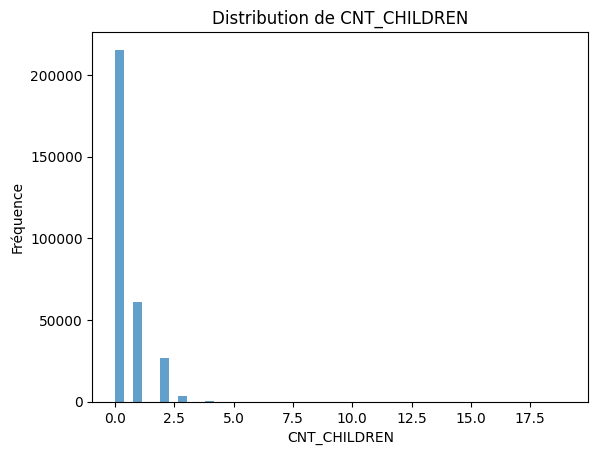

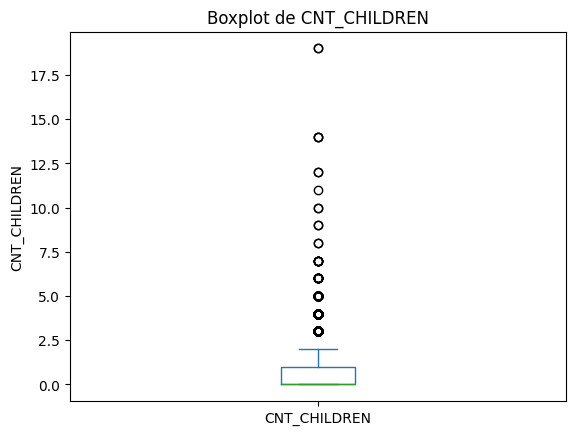

--- Analyse pour la variable : AMT_INCOME_TOTAL ---
0    202500.0
1    270000.0
2     67500.0
3    135000.0
4    121500.0
Name: AMT_INCOME_TOTAL, dtype: float64
Test de D’Agostino-Pearson : p-value = 0.0
   => Distribution non normale.


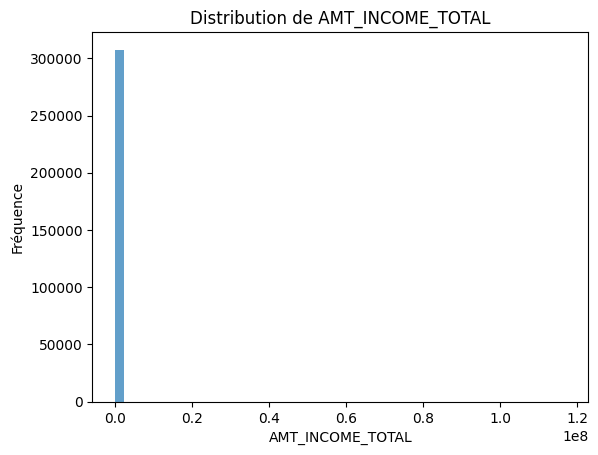

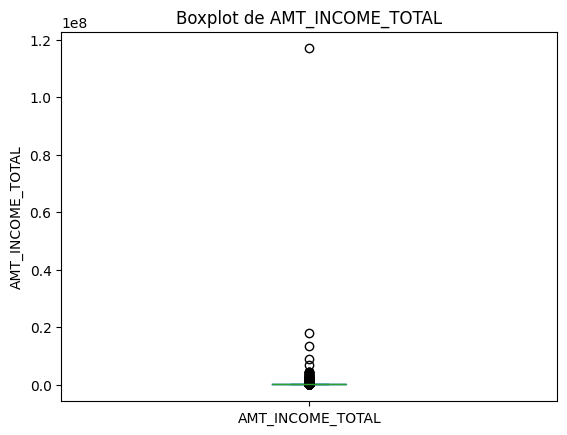

--- Analyse pour la variable : AMT_CREDIT ---
0     406597.5
1    1293502.5
2     135000.0
3     312682.5
4     513000.0
Name: AMT_CREDIT, dtype: float64
Test de D’Agostino-Pearson : p-value = 0.0
   => Distribution non normale.


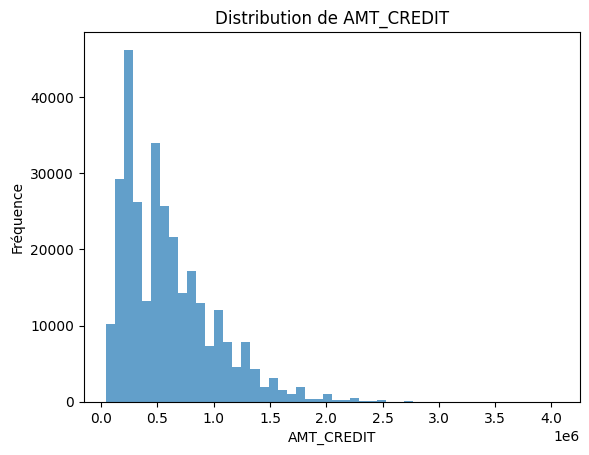

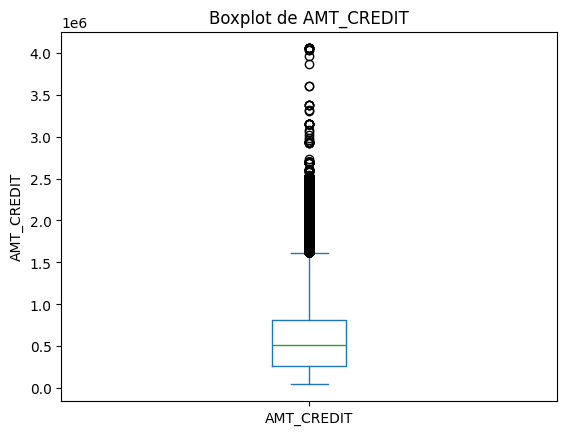

--- Analyse pour la variable : AMT_GOODS_PRICE ---
0     351000.0
1    1129500.0
2     135000.0
3     297000.0
4     513000.0
Name: AMT_GOODS_PRICE, dtype: float64
Test de D’Agostino-Pearson : p-value = 0.0
   => Distribution non normale.


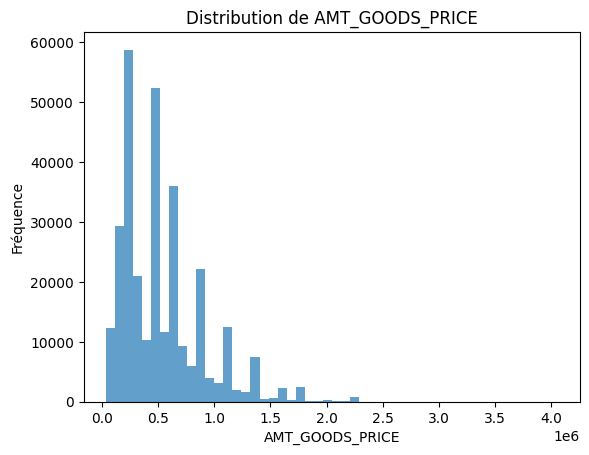

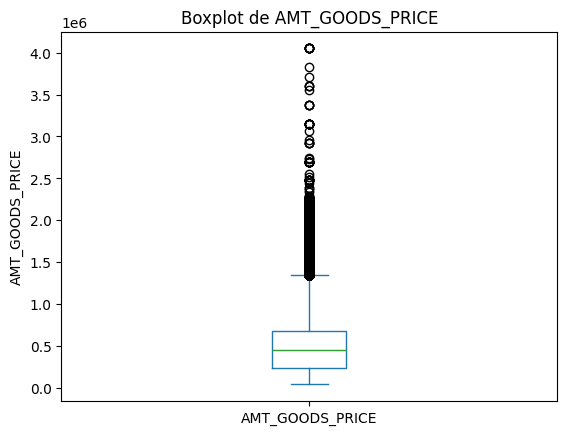

--- Analyse pour la variable : DAYS_BIRTH ---
0    -9461
1   -16765
2   -19046
3   -19005
4   -19932
Name: DAYS_BIRTH, dtype: int64
Test de D’Agostino-Pearson : p-value = 0.0
   => Distribution non normale.


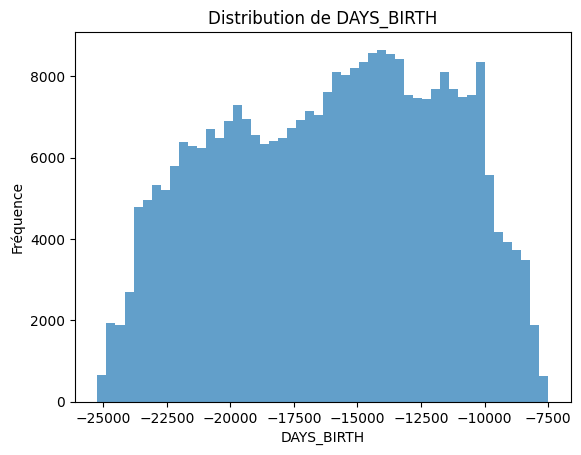

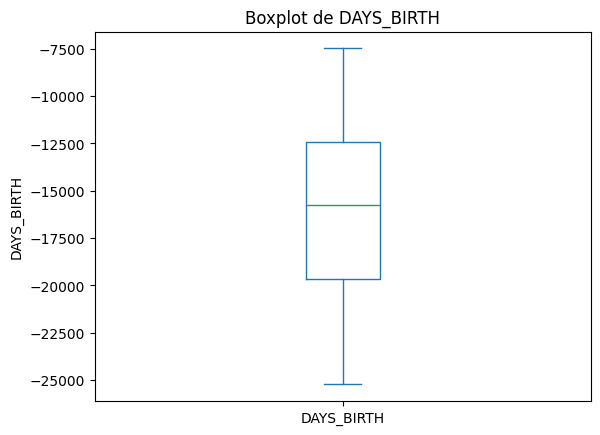

--- Analyse pour la variable : DAYS_EMPLOYED ---
0    -637
1   -1188
2    -225
3   -3039
4   -3038
Name: DAYS_EMPLOYED, dtype: int64
Test de D’Agostino-Pearson : p-value = 0.0
   => Distribution non normale.


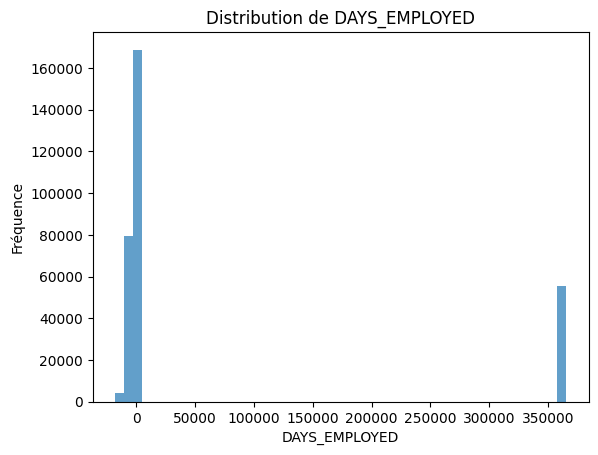

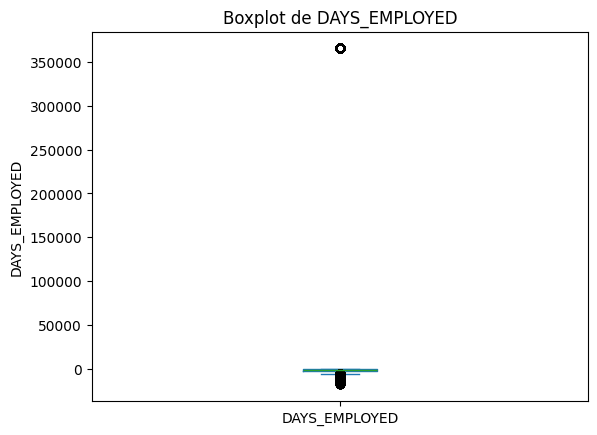

--- Analyse pour la variable : TOTALAREA_MODE ---
0     0.0149
1     0.0714
12    0.0612
13    0.1417
14    0.3811
Name: TOTALAREA_MODE, dtype: float64
Test de D’Agostino-Pearson : p-value = 0.0
   => Distribution non normale.


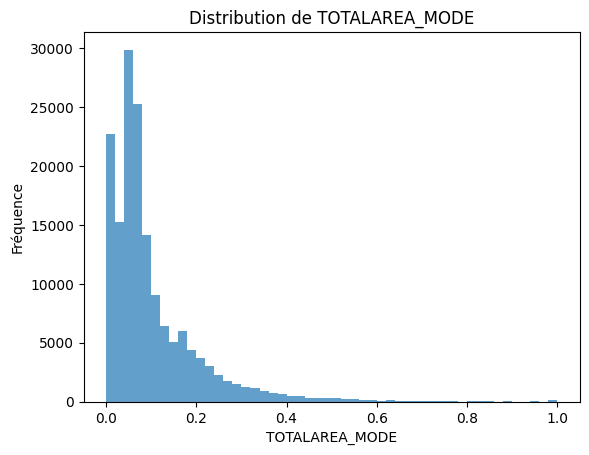

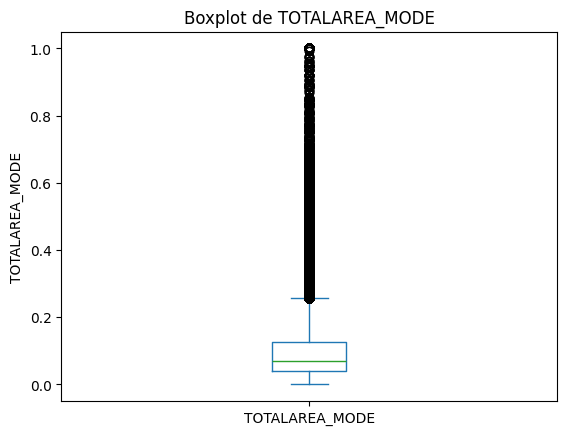

--- Analyse pour la variable : EXT_SOURCE_1 ---
0     0.083037
1     0.311267
6     0.774761
8     0.587334
10    0.319760
Name: EXT_SOURCE_1, dtype: float64
Test de D’Agostino-Pearson : p-value = 0.0
   => Distribution non normale.


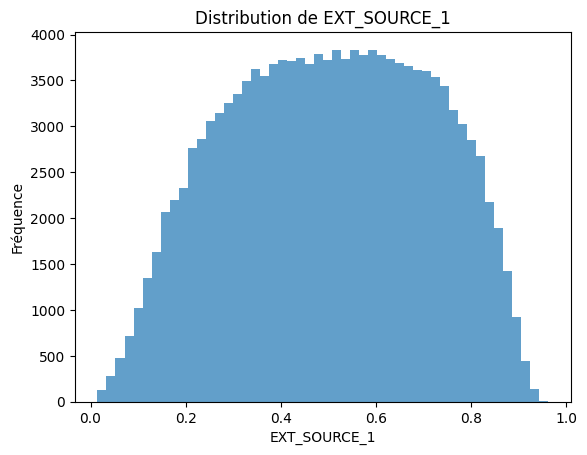

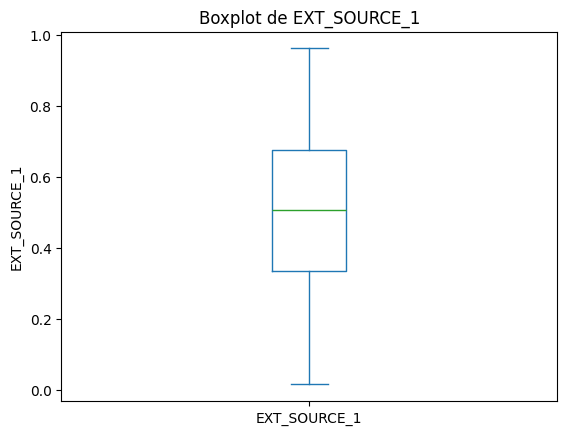

--- Analyse pour la variable : EXT_SOURCE_2 ---
0    0.262949
1    0.622246
2    0.555912
3    0.650442
4    0.322738
Name: EXT_SOURCE_2, dtype: float64
Test de D’Agostino-Pearson : p-value = 0.0
   => Distribution non normale.


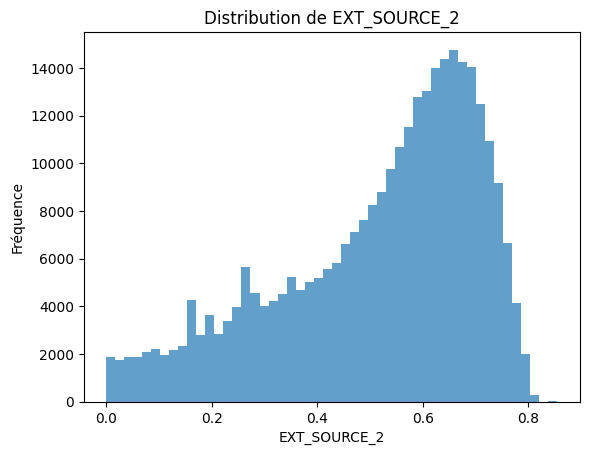

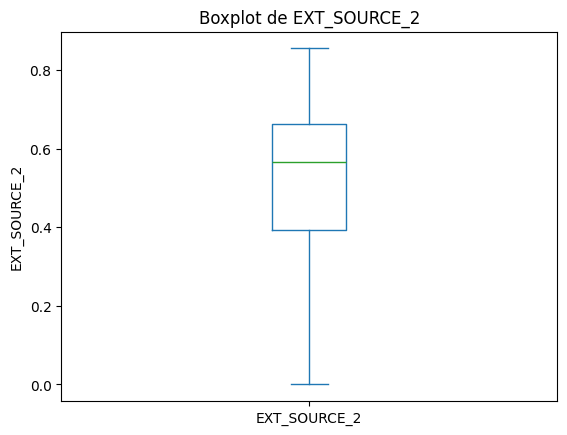

--- Analyse pour la variable : EXT_SOURCE_3 ---
0    0.139376
2    0.729567
5    0.621226
6    0.492060
7    0.540654
Name: EXT_SOURCE_3, dtype: float64
Test de D’Agostino-Pearson : p-value = 0.0
   => Distribution non normale.


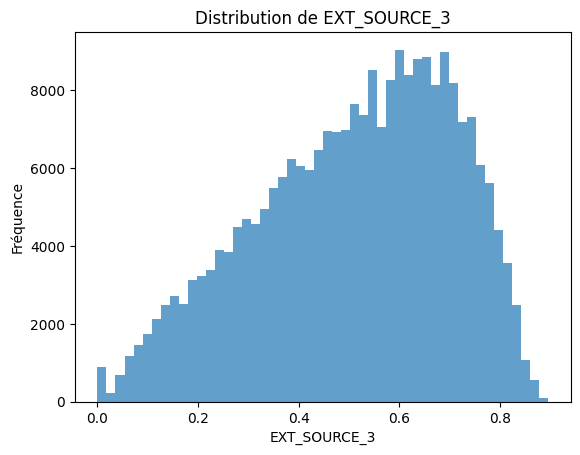

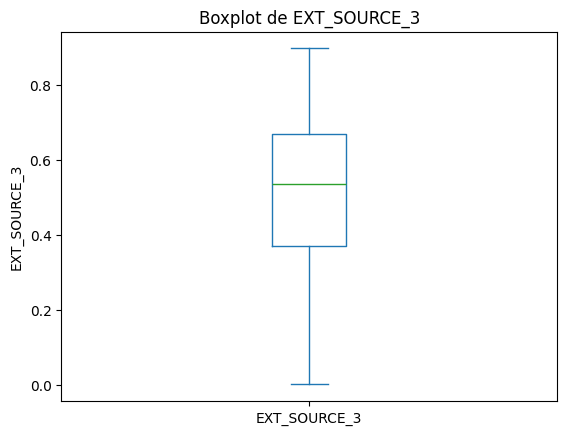

--- Analyse pour la variable : AMT_REQ_CREDIT_BUREAU_YEAR ---
0    1.0
1    0.0
2    0.0
4    0.0
5    1.0
Name: AMT_REQ_CREDIT_BUREAU_YEAR, dtype: float64
Test de D’Agostino-Pearson : p-value = 0.0
   => Distribution non normale.


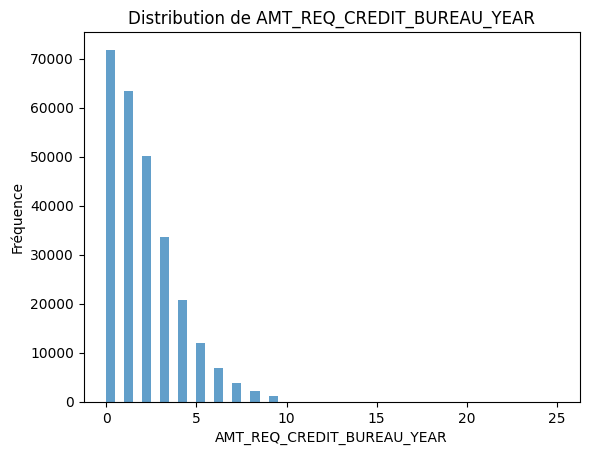

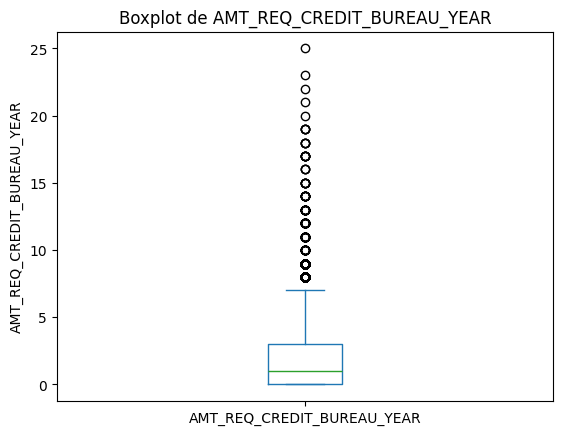

In [24]:
import pandas as pd
import os 
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from scipy.stats import normaltest

# Obtenir le répertoire courant
script_dir = os.getcwd()

# Construire le chemin relatif
relative_path = os.path.join(script_dir, '../ressources_prof/client_credit_granting.csv')

# Charger les données
df = pd.read_csv(relative_path)

# Identifier les types de variables
categorical_vars = [
    'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
    'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
    'NAME_CONTRACT_TYPE', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE'
]
binary_vars = ['GOOD_PAYER']
quantitative_vars = [
    'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_GOODS_PRICE',
    'DAYS_BIRTH', 'DAYS_EMPLOYED', 'TOTALAREA_MODE',
    'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'AMT_REQ_CREDIT_BUREAU_YEAR'
]

# Analyse univariée : variables quantitatives
for var in quantitative_vars:
    print(f'--- Analyse pour la variable : {var} ---')
    
    # Calculs descriptifs
    mean_val = df[var].mean()
    std_val = df[var].std()
    
    # Test de Shapiro-Wilk pour la normalité
    clean_data = df[var].dropna()  # Retirer les valeurs manquantes
    print(clean_data.head())
    stat, p_value = normaltest(clean_data)
    print(f'Test de D’Agostino-Pearson : p-value = {p_value}')
    if p_value < 0.05:
        print(f'   => Distribution non normale.')
    else:
        print(f'   => Distribution normale.')
    
    # Histogramme de la distribution
    df[var].plot(kind='hist', bins=50, title=f'Distribution de {var}', alpha=0.7)
    plt.xlabel(var)
    plt.ylabel('Fréquence')
    plt.show()

    # Boxplot de la variable
    df[var].plot(kind='box', title=f'Boxplot de {var}')
    plt.ylabel(var)
    plt.show()





Retraitement 

Valeur de AMT_INCOME_TOTAL : la plus haute valeur est abérrante.

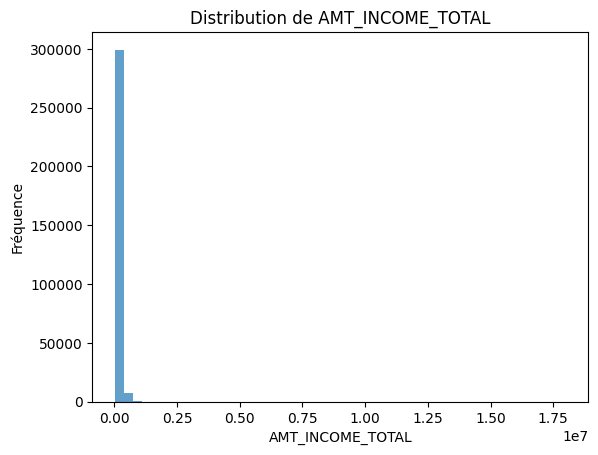

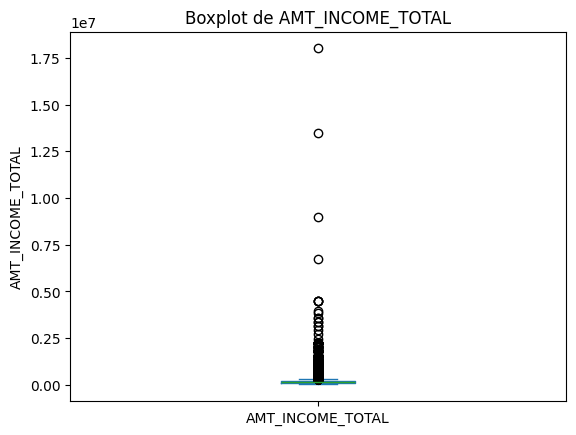

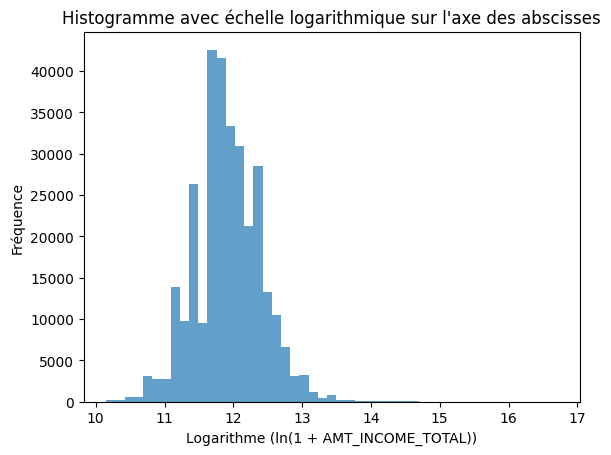

In [25]:
df = df[df["AMT_INCOME_TOTAL"] < 100_000_000]

# On va voir la nouvelle tete de la distribution et du boxplot une fois la valeur abérrante enlevée : 

for var in ["AMT_INCOME_TOTAL"]:
    
    df[var].plot(kind='hist', bins=50, title=f'Distribution de {var}', alpha=0.7)
    plt.xlabel(var)
    plt.ylabel('Fréquence')
    plt.show()

    # Boxplot de la variable
    df[var].plot(kind='box', title=f'Boxplot de {var}')
    plt.ylabel(var)
    plt.show()
# print("----------------\n\n---------------------\n\n")

# on a quand même des clients qui ont plusieurs millions et qui demandent des prêts. 
# Ils écraseent la disctribution et on a du mal à bien voir. On va faire un plot logarithmique.

# Appliquer le logarithme à l'axe des x pour mieux visualiser les données
df['LOG_AMT_INCOME_TOTAL'] = np.log1p(df['AMT_INCOME_TOTAL'])

# Créer un histogramme logarithmique
bins = np.linspace(df['LOG_AMT_INCOME_TOTAL'].min(), df['LOG_AMT_INCOME_TOTAL'].max(), 50)
plt.hist(df['LOG_AMT_INCOME_TOTAL'], bins=bins, alpha=0.7)

plt.title('Histogramme avec échelle logarithmique sur l\'axe des abscisses')
plt.xlabel('Logarithme (ln(1 + AMT_INCOME_TOTAL))')
plt.ylabel('Fréquence')
plt.show()



Prochain retraitement : DAYS_BIRTH. Toutes les valeurs sont négatives. Il faudrait qu'elles soient positives.


In [26]:

df["DAYS_BIRTH"] = df['DAYS_BIRTH'].map(lambda x: -x)

print(df['DAYS_BIRTH'])


0          9461
1         16765
2         19046
3         19005
4         19932
          ...  
307506     9327
307507    20775
307508    14966
307509    11961
307510    16856
Name: DAYS_BIRTH, Length: 307510, dtype: int64


Prochain retraitement : DAYS_EMPLOYED
50 000 employés ont travaillé exactement 365 243 jours soit à peu près 1000 ans d'affilé. 
C'est assez peu vraisemblable, donc on peut se permettre de supprimer ces valeurs.

On a également certaines valeurs négatives... On va les conserver en les transformant en valeur positive.

0          637
1         1188
2          225
3         3039
4         3038
          ... 
307504    7258
307506     236
307508    7921
307509    4786
307510    1262
Name: DAYS_EMPLOYED, Length: 252136, dtype: int64


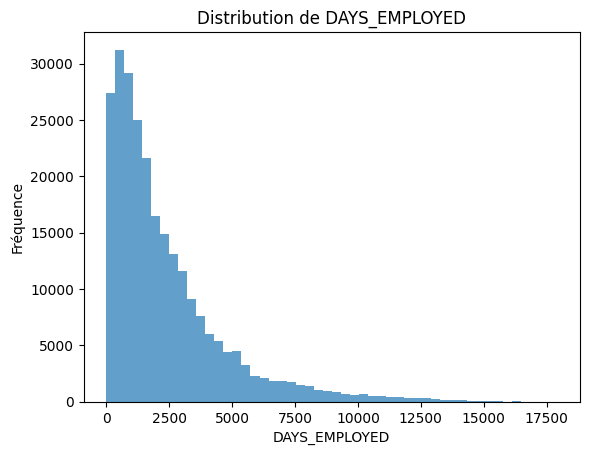

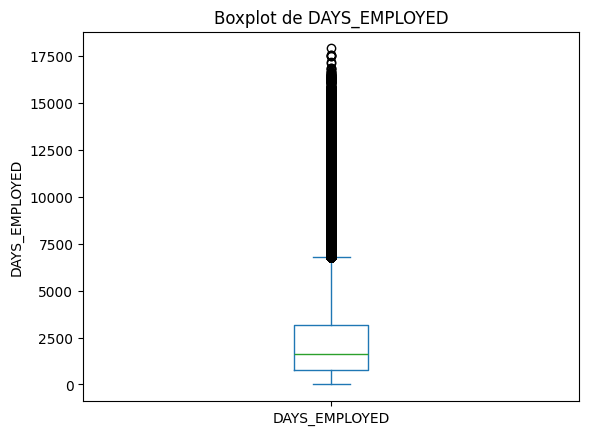

In [27]:
df["DAYS_EMPLOYED"] = df["DAYS_EMPLOYED"].map (lambda x: abs(x) )

df = df[ df["DAYS_EMPLOYED"] < 365_242]

print(df["DAYS_EMPLOYED"])

for var in ["DAYS_EMPLOYED"]:
    
    df[var].plot(kind='hist', bins=50, title=f'Distribution de {var}', alpha=0.7)
    plt.xlabel(var)
    plt.ylabel('Fréquence')
    plt.show()

    # Boxplot de la variable
    df[var].plot(kind='box', title=f'Boxplot de {var}')
    plt.ylabel(var)
    plt.show()




### Variables catégorielles

--- Analyse pour la variable : CODE_GENDER ---


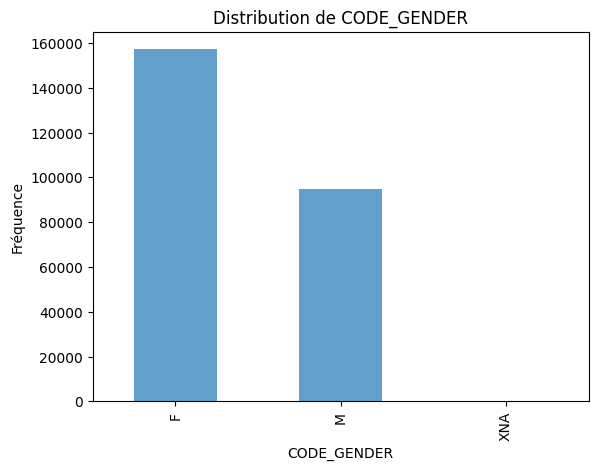

--- Analyse pour la variable : FLAG_OWN_CAR ---


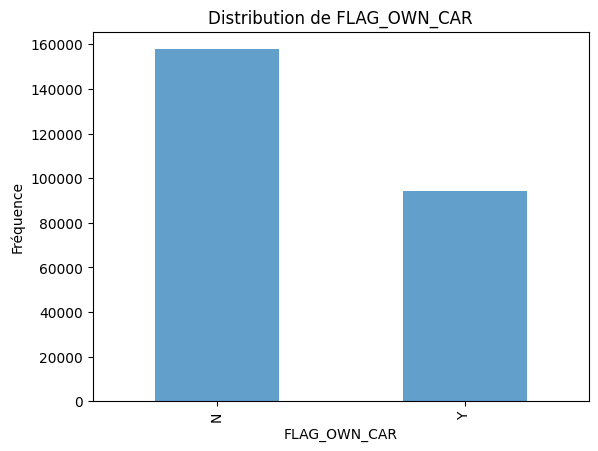

--- Analyse pour la variable : FLAG_OWN_REALTY ---


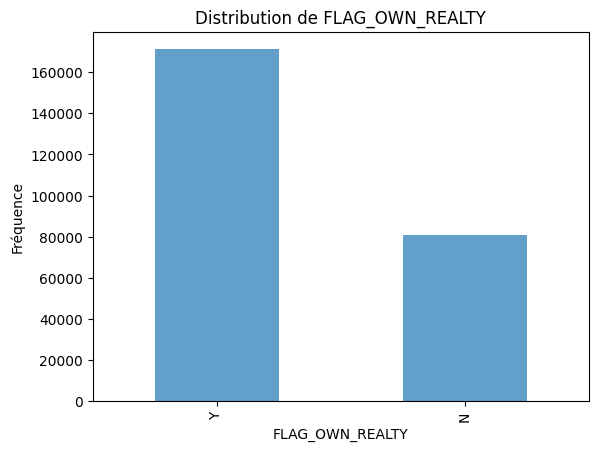

--- Analyse pour la variable : NAME_INCOME_TYPE ---


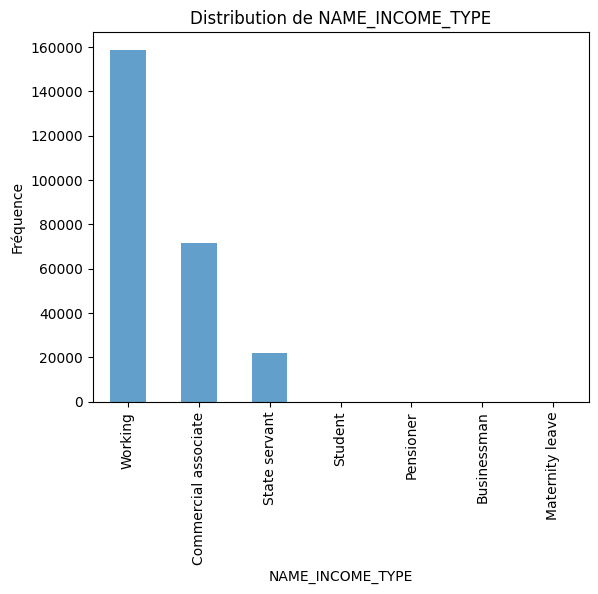

--- Analyse pour la variable : NAME_EDUCATION_TYPE ---


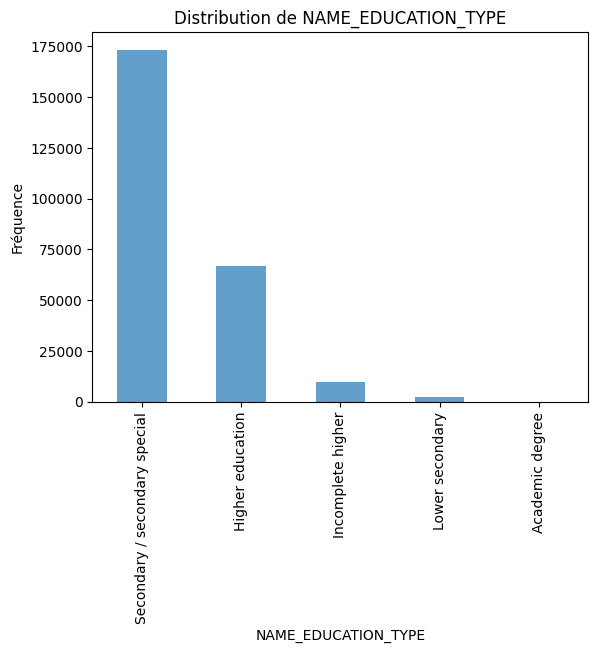

--- Analyse pour la variable : NAME_FAMILY_STATUS ---


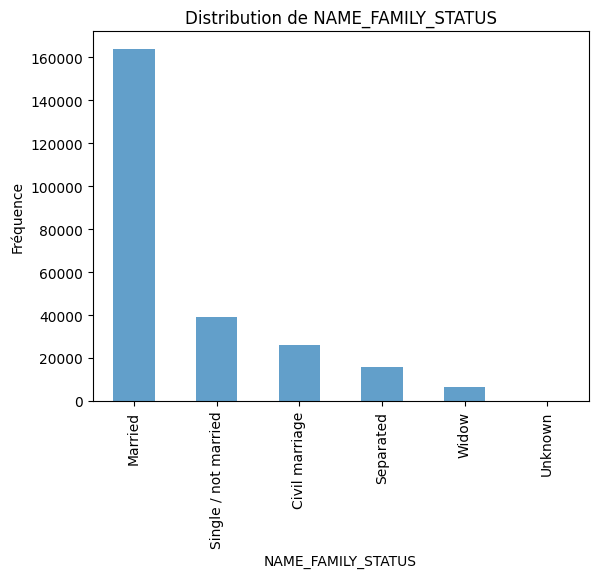

--- Analyse pour la variable : NAME_CONTRACT_TYPE ---


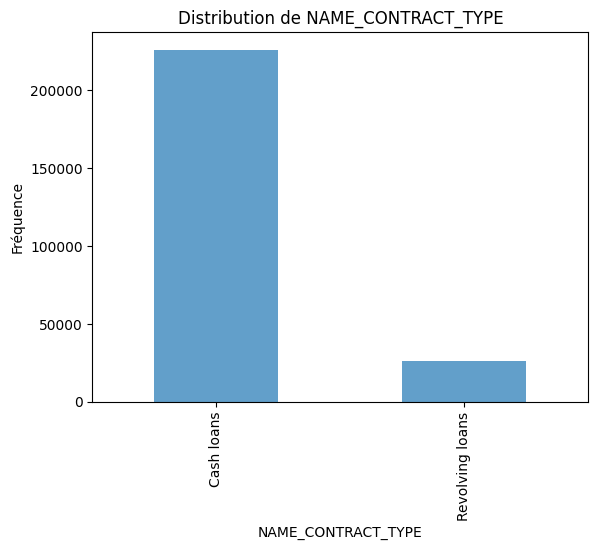

--- Analyse pour la variable : NAME_HOUSING_TYPE ---


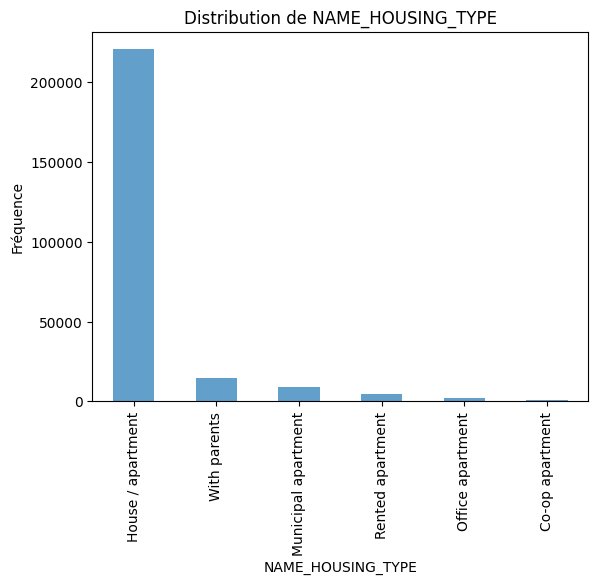

--- Analyse pour la variable : OCCUPATION_TYPE ---


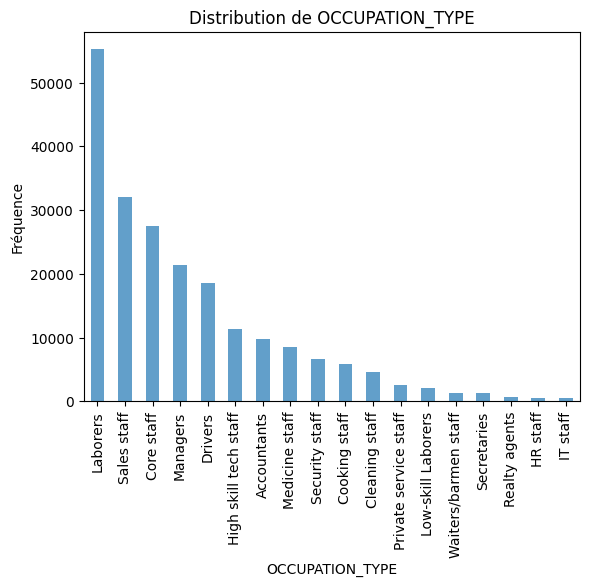

--- Analyse pour la variable : ORGANIZATION_TYPE ---


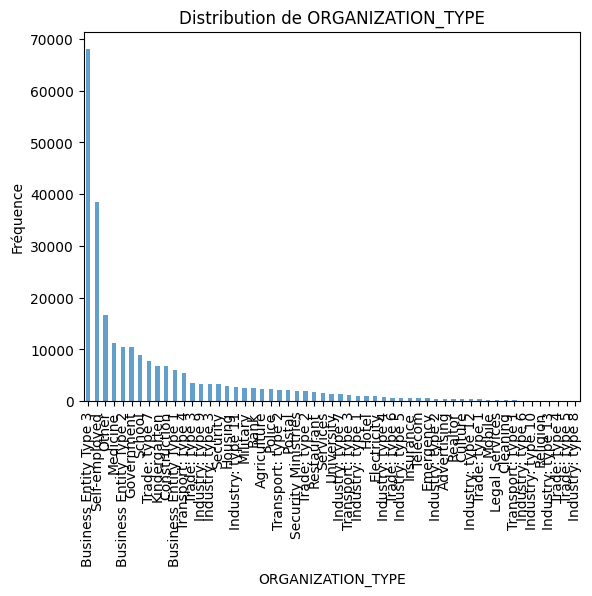

In [28]:
for var in categorical_vars:
    print(f'--- Analyse pour la variable : {var} ---')
    
    # Histogramme de la distribution
    df[var].value_counts().plot(kind='bar', title=f'Distribution de {var}', alpha=0.7)
    plt.xlabel(var)
    plt.ylabel('Fréquence')
    plt.show()

Pas de retraitement à faire pour les variables catégorielles

--- Analyse pour la variable : GOOD_PAYER ---


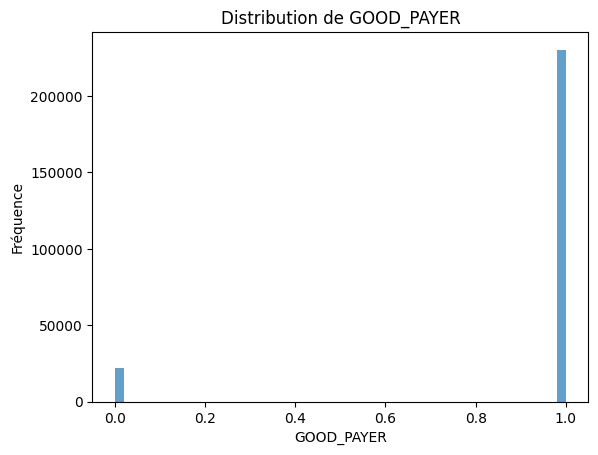

In [29]:
for var in binary_vars:
    print(f'--- Analyse pour la variable : {var} ---')
    
    # Histogramme de la distribution
    df[var].plot(kind='hist', bins=50, title=f'Distribution de {var}', alpha=0.7)
    plt.xlabel(var)
    plt.ylabel('Fréquence')
    plt.show()

### Analyse bivariée

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency, pearsonr

# Identifier les types de variables
categorical_vars = [
    'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
    'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
    'NAME_CONTRACT_TYPE', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE'
]

quantitative_vars = [
    'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_GOODS_PRICE',
    'DAYS_BIRTH', 'DAYS_EMPLOYED', 'TOTALAREA_MODE',
    'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'AMT_REQ_CREDIT_BUREAU_YEAR'
]

target_var = 'GOOD_PAYER'

# Analyse bivariée : variables quantitatives
print("=== Analyse bivariée : Variables quantitatives ===")
for var in quantitative_vars:
    if var in df.columns:
        print(f'\n--- Analyse pour la variable : {var} ---')
        
        # Retirer les valeurs manquantes
        clean_data = df[[var, target_var]].dropna()
        
        if not clean_data.empty:
            # Test de corrélation de Pearson
            correlation, p_value = pearsonr(clean_data[var], clean_data[target_var])
            print(f"Corrélation (Pearson) : {correlation:.4f}, p-value : {p_value:.4f}")
            if p_value < 0.05:
                print("   => Corrélation significative.")
            else:
                print("   => Pas de corrélation significative.")

# Analyse bivariée : variables catégoriques
print("\n=== Analyse bivariée : Variables catégoriques ===")
for var in categorical_vars:
    if var in df.columns:
        print(f'\n--- Analyse pour la variable : {var} ---')
        
        # Créer une table de contingence
        contingency_table = pd.crosstab(df[var], df[target_var])
        
        # Test du chi-carré
        chi2, p_value, _, _ = chi2_contingency(contingency_table)
        print(f"Test du chi-carré : Chi2 = {chi2:.4f}, p-value = {p_value:.4f}")
        if p_value < 0.05:
            print("   => Relation significative avec la variable cible.")
        else:
            print("   => Pas de relation significative avec la variable cible.")


=== Analyse bivariée : Variables quantitatives ===

--- Analyse pour la variable : CNT_CHILDREN ---
Corrélation (Pearson) : -0.0077, p-value : 0.0001
   => Corrélation significative.

--- Analyse pour la variable : AMT_INCOME_TOTAL ---
Corrélation (Pearson) : 0.0300, p-value : 0.0000
   => Corrélation significative.

--- Analyse pour la variable : AMT_CREDIT ---
Corrélation (Pearson) : 0.0407, p-value : 0.0000
   => Corrélation significative.

--- Analyse pour la variable : AMT_GOODS_PRICE ---
Corrélation (Pearson) : 0.0503, p-value : 0.0000
   => Corrélation significative.

--- Analyse pour la variable : DAYS_BIRTH ---
Corrélation (Pearson) : 0.0657, p-value : 0.0000
   => Corrélation significative.

--- Analyse pour la variable : DAYS_EMPLOYED ---
Corrélation (Pearson) : 0.0750, p-value : 0.0000
   => Corrélation significative.

--- Analyse pour la variable : TOTALAREA_MODE ---
Corrélation (Pearson) : 0.0368, p-value : 0.0000
   => Corrélation significative.

--- Analyse pour la vari

Toutes les variables sont significativement corrélées avec la variable cible, ce qui en fait de bons prédicteurs de la variable cible ('GOOD PAYER')

Il y a néamoins une exception : la variable 'FLAG_OWN_REALTY'. 

Par défaut, on gardera cette variable pour construire notre modèle. Supprimer cette variable de l'entraînement de notre modèle restera néamoins une piste à explorer pour d'éventuelles améliorations.

Matrice de Variance-Covariance 

Matrice de variance-covariance (quantitatives) :
                            CNT_CHILDREN  AMT_INCOME_TOTAL    AMT_CREDIT  \
CNT_CHILDREN                    0.578155     -1.587514e+03 -5.636767e+03   
AMT_INCOME_TOTAL            -1587.513828      1.232763e+10  1.739910e+10   
AMT_CREDIT                  -5636.767371      1.739910e+10  1.875806e+11   
AMT_GOODS_PRICE             -6848.740293      1.628789e+10  1.707272e+11   
DAYS_BIRTH                   -519.933179      3.341954e+07  2.564274e+08   
DAYS_EMPLOYED                 -79.367811      7.536988e+06  7.963609e+07   
TOTALAREA_MODE                 -0.001490      1.567309e+03  3.340154e+03   
EXT_SOURCE_1                   -0.013994      2.637204e+03  1.601408e+04   
EXT_SOURCE_2                   -0.001635      2.728607e+03  9.546647e+03   
EXT_SOURCE_3                   -0.000928     -1.121537e+03  4.843802e+03   
AMT_REQ_CREDIT_BUREAU_YEAR     -0.032394      2.545109e+03 -4.476603e+04   

                            AMT_GOODS_

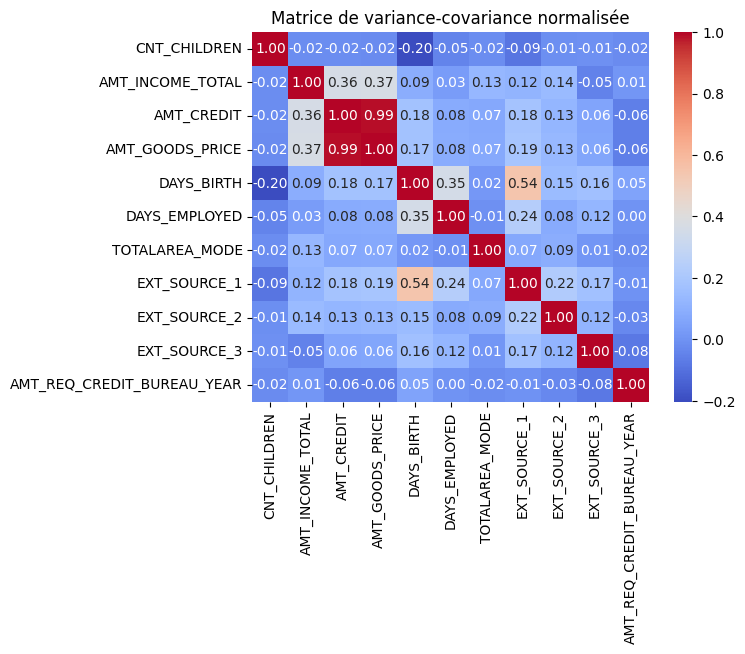

In [31]:
# Extraire les variables quantitatives et retirer les valeurs manquantes
quantitative_data = df[quantitative_vars].dropna()

# Calculer la matrice de variance-covariance
cov_matrix = quantitative_data.cov()



# Afficher la matrice
print("Matrice de variance-covariance (quantitatives) :")
print(cov_matrix)

import seaborn as sns 

# Normalisation des variables quantitatives
quantitative_data_normalized = (quantitative_data - quantitative_data.mean()) / quantitative_data.std()

# Calcul de la nouvelle matrice de variance-covariance
cov_matrix_normalized = quantitative_data_normalized.cov()

# Heatmap avec les données normalisées
sns.heatmap(cov_matrix_normalized, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matrice de variance-covariance normalisée")
plt.show()


On remarque que les variables "AMT_CREDIT" et "AMT_GOODS_PRICE" sont très fortement corrélées. 
Cela paraît évident à postériori : Il est logique que la valeur du crédit soit très proche de la valeur du bien que l'on achète avec. 

Pour éviter la redondance, on peut donc supprimer une des deux informations de notre jeux de données. On va supprimer "AMT_GOODS_PRICE"

In [32]:

df.drop("AMT_GOODS_PRICE",axis = 1, inplace=True)

Matrice de variance-covariance (quantitatives) :
                            CNT_CHILDREN  AMT_INCOME_TOTAL    AMT_CREDIT  \
CNT_CHILDREN                    0.577924     -1.588687e+03 -5.616681e+03   
AMT_INCOME_TOTAL            -1588.687118      1.232146e+10  1.740543e+10   
AMT_CREDIT                  -5616.680895      1.740543e+10  1.875500e+11   
DAYS_BIRTH                   -519.289437      3.349320e+07  2.567651e+08   
DAYS_EMPLOYED                 -79.140823      7.553422e+06  7.971776e+07   
TOTALAREA_MODE                 -0.001488      1.568673e+03  3.351731e+03   
EXT_SOURCE_1                   -0.013963      2.638292e+03  1.602125e+04   
EXT_SOURCE_2                   -0.001618      2.729484e+03  9.554017e+03   
EXT_SOURCE_3                   -0.000921     -1.118063e+03  4.860206e+03   
AMT_REQ_CREDIT_BUREAU_YEAR     -0.032399      2.534894e+03 -4.471391e+04   

                              DAYS_BIRTH  DAYS_EMPLOYED  TOTALAREA_MODE  \
CNT_CHILDREN               -5.192894e+0

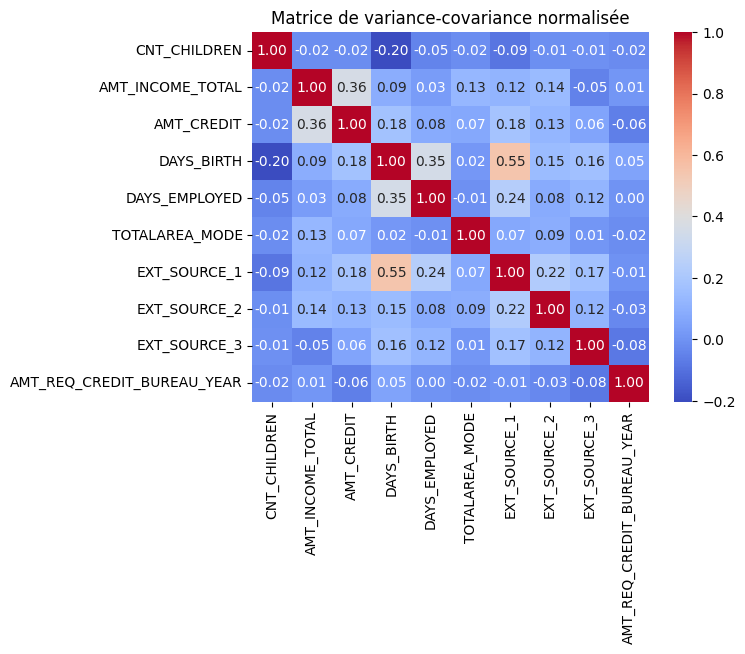

In [33]:
# Redéfinir la nouvelle liste des variables quantitatives
quantitative_vars = [
    'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
    'DAYS_BIRTH', 'DAYS_EMPLOYED', 'TOTALAREA_MODE',
    'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'AMT_REQ_CREDIT_BUREAU_YEAR'
]

# Extraire les variables quantitatives et retirer les valeurs manquantes
quantitative_data = df[quantitative_vars].dropna()

# Calculer la matrice de variance-covariance
cov_matrix = quantitative_data.cov()



# Afficher la matrice
print("Matrice de variance-covariance (quantitatives) :")
print(cov_matrix)

import seaborn as sns 

# Normalisation des variables quantitatives
quantitative_data_normalized = (quantitative_data - quantitative_data.mean()) / quantitative_data.std()

# Calcul de la nouvelle matrice de variance-covariance
cov_matrix_normalized = quantitative_data_normalized.cov()

# Heatmap avec les données normalisées
sns.heatmap(cov_matrix_normalized, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matrice de variance-covariance normalisée")
plt.show()

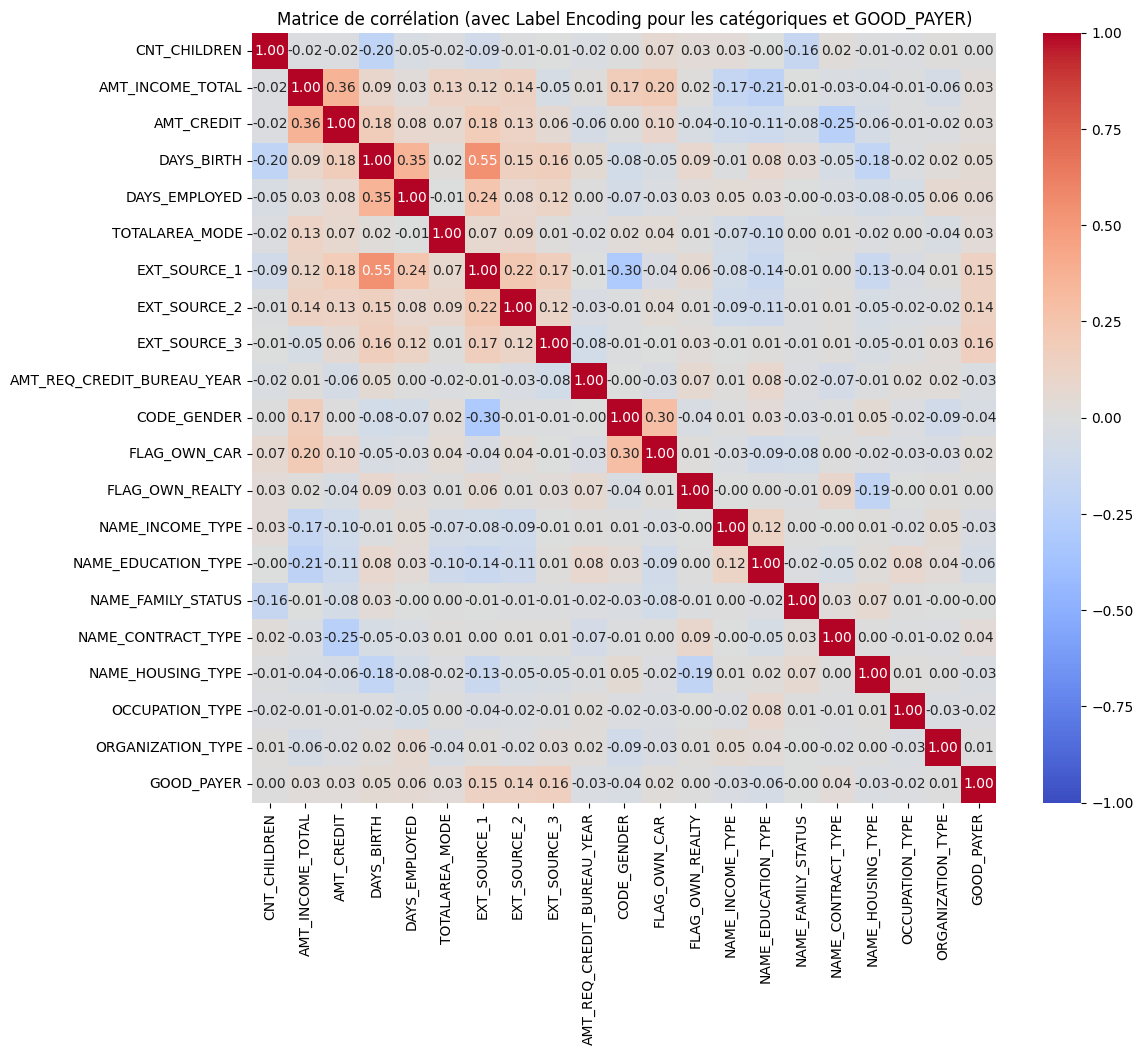

In [34]:
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

# Créer une copie temporaire du DataFrame pour l'encodage
df_temp = df.copy()

# Encoder les variables catégoriques avec Label Encoding (uniquement pour cette matrice)
label_encoder = LabelEncoder()
for col in categorical_vars:
    df_temp[col] = label_encoder.fit_transform(df_temp[col].fillna('Unknown'))

# Ajouter la variable cible "GOOD_PAYER" aux variables combinées
combined_vars = quantitative_vars + categorical_vars + ['GOOD_PAYER']

# Combiner les variables quantitatives, catégoriques encodées et la cible
combined_data = df_temp[combined_vars].dropna()

# Calculer la matrice de corrélation
correlation_matrix = combined_data.corr()

# Visualiser la matrice de corrélation
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Matrice de corrélation (avec Label Encoding pour les catégoriques et GOOD_PAYER)")
plt.show()

On remarque que la variable cible est fortement corrélée aux scores prédictif. Ce qui est bon signe. 
Également, les scores prédictifs sont fortement corrélés entre eux, ce qui paraît logique. 

# Des détails supplémentaires sur quelques variables
Maintenant que l'on travaille avec des données saines, pour compléter l'analyse  descriptive, voici quelques chiffres sur les données que l'on manipule : 

In [35]:
total_clients = df.shape[0]
bad_payer_count = df['GOOD_PAYER'].value_counts().get(0, 0)
car_owners = df['FLAG_OWN_CAR'].value_counts().get('Y', 0)  # Supposant que 'Y' indique possession d'une voiture
avg_children = df['CNT_CHILDREN'].mean()
income_mean = df['AMT_INCOME_TOTAL'].mean()
income_std = df['AMT_INCOME_TOTAL'].std()
avg_age = (df['DAYS_BIRTH'].mean() / 365)  # Convertir les jours en années

# Affichage des résultats
print("Statistiques descriptives :")
print(f"- Nombre total de clients : {total_clients}")
print(f"- Nombre de mauvais payeur : {bad_payer_count}")
print(f"- Nombre de clients possédant une voiture : {car_owners}")
print(f"- Nombre moyen d'enfants par client : {avg_children:.2f}")
print(f"- Revenu moyen : {income_mean:.2f}, Écart-type : {income_std:.2f}")
print(f"- Âge moyen des empruntants : {avg_age:.1f} ans")

Statistiques descriptives :
- Nombre total de clients : 252136
- Nombre de mauvais payeur : 21834
- Nombre de clients possédant une voiture : 94418
- Nombre moyen d'enfants par client : 0.50
- Revenu moyen : 175450.73, Écart-type : 113468.02
- Âge moyen des empruntants : 40.5 ans


### Étape 1 : Préparation des datasets
- Préparation une base de train, de validation et de test (60% / 20% / 20%)

In [37]:
from sklearn.model_selection import train_test_split

data = df.copy()

# Séparation en features (X) et cible (y)
X = data.drop(columns=["GOOD_PAYER", "SK_ID_CURR"])
y = data["GOOD_PAYER"]

# Division des données en jeu d'entraînement, validation et test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Vérification des tailles
print(f"Train: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")


Train: (151281, 21), Validation: (50427, 21), Test: (50428, 21)


### Étape 2 : Préparation des datasets

- Stratification des clients dans l’ensemble des échantillons. Cela signifie que lors de la séparation des données (entraînement, validation, et test), on s'assure que la proportion des classes de la variable cible (GOOD_PAYER) est conservée dans chaque échantillon.
